In [1]:
import os
os.chdir(path='../..')
import scanpy as sc
import plotly.express as px
import matplotlib.pyplot as plt
import STForte.helper as stfhelper
import numpy as np
from copy import deepcopy
from STForte import STGraph
from STForte import STForteModel
from STForte.helper import save_gdata

np.random.seed(42)
sc.set_figure_params(dpi=120, transparent=True, dpi_save=400, frameon=False, vector_friendly=False, format="pdf")
trial_name = "trial-OSCC/sample_1"
plot_dir = f"./{trial_name}/plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
sc.settings.figdir = plot_dir
plt.rcParams['font.sans-serif'] = [
    'Helvetica',
    'Arial',
    'sans-serif',]
palette = px.colors.qualitative.Plotly

import warnings
warnings.filterwarnings('ignore')

/home/wcx99075523/miniconda3/envs/stforte/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Global seed set to 0


In [2]:
adata = sc.read_h5ad(f'data/OSCC/sample_1/sample_1_preprocessed.h5ad')
adata

AnnData object with n_obs × n_vars = 1131 × 15844
    obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y'
    uns: 'pathologist_anno.x_colors', 'spatial'
    obsm: 'spatial'
    layers: 'processed'

In [3]:
d = adata.uns['spatial']['stomic']['scalefactors']['fiducial_diameter_fullres']
stgraph = STGraph.graphFromAnndata(
    adata=adata,
    d=d,
    )

d-based initialize:   0%|          | 0/1131 [00:00<?, ?it/s]

In [4]:
def random_mask(adata, stgraph, propotions, load_mask=True, random_state=42):
    np.random.seed(random_state)
    results = dict()
    for p in propotions:
        stg = deepcopy(stgraph)
        if load_mask:
            mask_id = np.load(f"{trial_name}/outputs/mask_id_{p}.npy",allow_pickle=True)
            obs_names = adata.obs_names.to_numpy()
            idx = [np.argwhere(obs_names==i).item() for i in mask_id]
        else:
            idx = np.random.choice(np.arange(stgraph.node_attr.shape[0]),int(stgraph.node_attr.shape[0]*p),replace=False)
        stg.mask_nodes(mask_idx=idx)
        results[f'Mask_{p}'] = stg
    return results

In [5]:
masked_stgs = random_mask(adata, stgraph, propotions=[0.1,0.3,0.5,0.7])

In [6]:
for key in masked_stgs.keys():
    adata.obs[key] = masked_stgs[key].node_stat
    adata.obs[key] = adata.obs[key].astype('category')

In [7]:
gdatas = dict()
for key, stg in masked_stgs.items():
    stg.pca()
    gdatas[key] = stg.topyg()

PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 4.41s.
FP
PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 0.50s.
FP
PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 0.32s.
FP
PCA pre-compression for data, from 15840 onto 300-dim.
Scaling data: None; SVD solver: full; random_state=42.
Start compression...	Done! Elapsed time: 0.17s.
FP


In [8]:
adata_sp_dict = dict()
for key, gdata in gdatas.items():
    model = STForteModel(adata=adata, gdata=gdata,
                     output_dir='./{:s}/pl_ckpts/'.format(trial_name),
                     module_kwargs=dict(hidden_gcns=[100, 50],lmbd_cross=1))
    model.fit()
    model.get_latent_original(adata)
    adata.obsm[f'STForte_COMB_{key}'] = adata.obsm['STForte_COMB']
    adata.obsm[f'STForte_ATTR_{key}'] = adata.obsm['STForte_ATTR']
    adata.obsm[f'STForte_TOPO_{key}'] = adata.obsm['STForte_TOPO'] 
    adata_sp_dict[key] = model.get_result_anndata()

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_03247b | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.736     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_15791f | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.736     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_27608c | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.736     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.
Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | attr_encoder  | Sequential        | 71.9 K
1 | strc_encoder  | Sequential_38b796 | 36.8 K
2 | attr_decoder  | Sequential        | 72.2 K
3 | strc_decoder  | Sequential        | 2.1 K 
4 | discriminator | Sequential        | 1.1 K 
----------------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.736     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


### Select gene and complete the gene expression

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=1000,subset=True)
adata

AnnData object with n_obs × n_vars = 1131 × 1000
    obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y', 'Mask_0.1', 'Mask_0.3', 'Mask_0.5', 'Mask_0.7', 'STForte_Mask'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'pathologist_anno.x_colors', 'spatial', 'log1p', 'hvg'
    obsm: 'spatial', 'STForte_ATTR', 'STForte_TOPO', 'STForte_COMB', 'STForte_COMB_Mask_0.1', 'STForte_ATTR_Mask_0.1', 'STForte_TOPO_Mask_0.1', 'STForte_COMB_Mask_0.3', 'STForte_ATTR_Mask_0.3', 'STForte_TOPO_Mask_0.3', 'STForte_COMB_Mask_0.5', 'STForte_ATTR_Mask_0.5', 'STForte_TOPO_Mask_0.5', 'STForte_COMB_Mask_0.7', 'STForte_ATTR_Mask_0.7', 'STForte_TOPO_Mask_0.7'
    layers: 'processed'

In [33]:
adata_sp = list(adata_sp_dict.values())[0]
for key in adata_sp_dict.keys():
    print(f"Complete expression of sample {key}...")
    stfhelper.complete_unseen_expression(
        adata_sp_dict[key], adata.var_names, adata, 'SP_ATTR_FP',xgb_params=dict(n_estimators=10, learning_rate=0.1)
    )

Complete expression of sample Mask_0.1...


Propagating genes...:   0%|          | 0/1000 [00:00<?, ?it/s]

Complete expression of sample Mask_0.3...


Propagating genes...:   0%|          | 0/1000 [00:00<?, ?it/s]

Complete expression of sample Mask_0.5...


Propagating genes...:   0%|          | 0/1000 [00:00<?, ?it/s]

Complete expression of sample Mask_0.7...


Propagating genes...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
for key in adata_sp_dict.keys():
    adata_sp_dict[key].write_loom(f"{trial_name}/outputs/adata_sp_{key}_attr.loom",write_obsm_varm=True)

In [13]:
for key in gdatas.keys():
    sc.pp.neighbors(adata, use_rep=f"STForte_ATTR_{key}")
    sc.tl.umap(adata)
    sc.tl.louvain(adata,resolution=0.4, key_added=f"louvain_{key}")

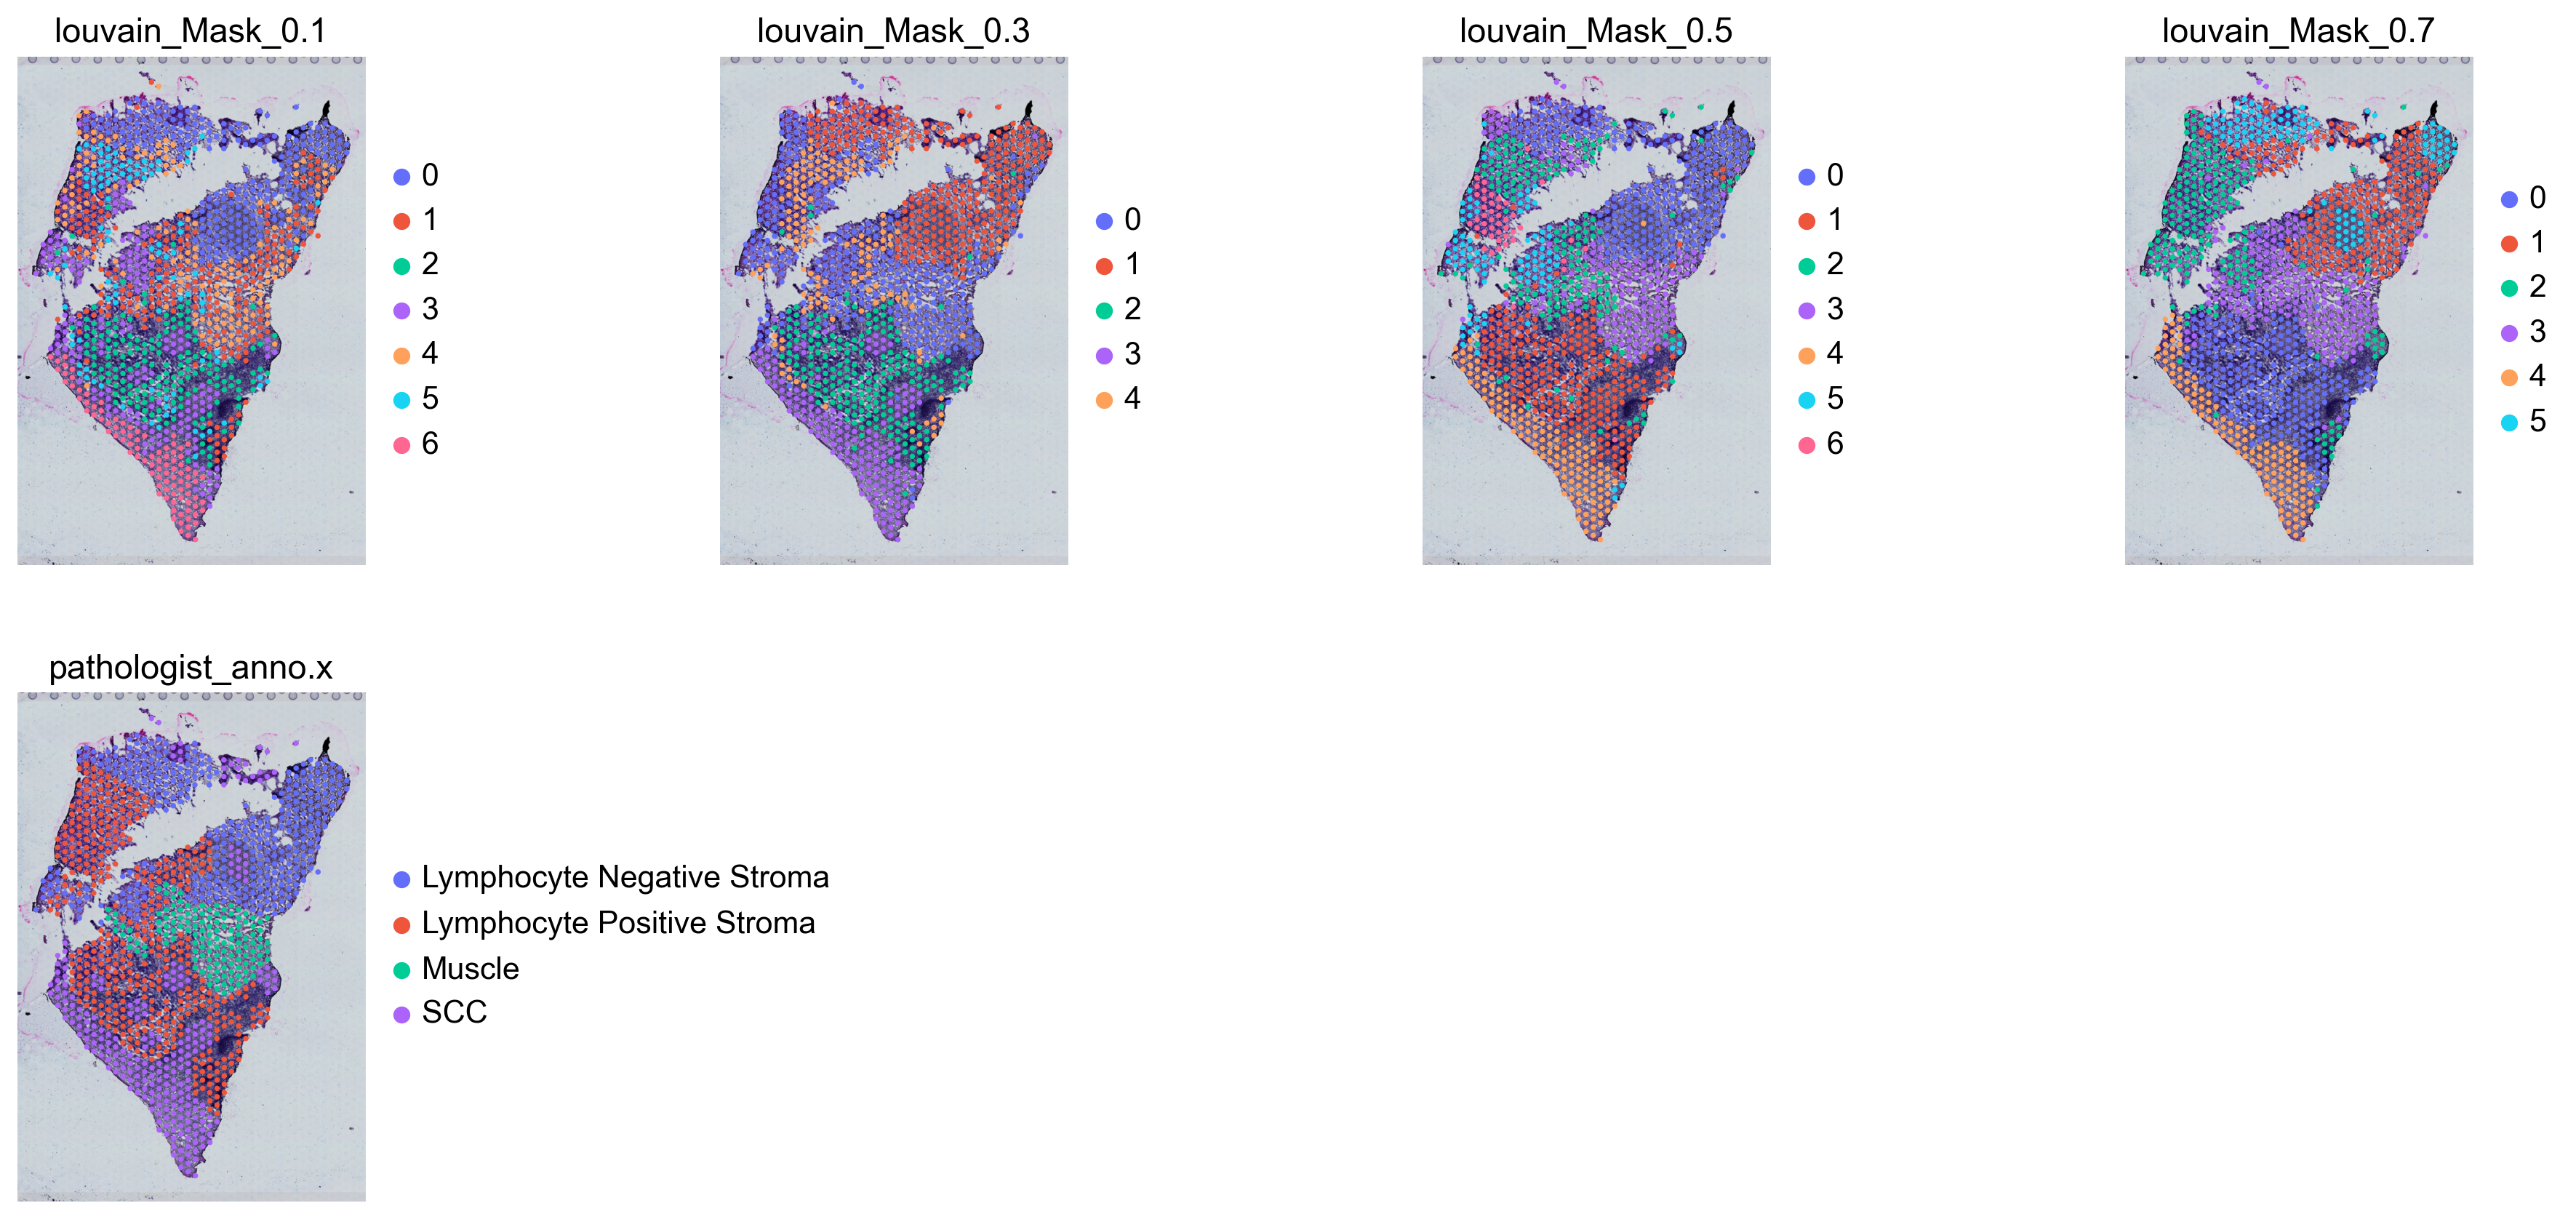

In [14]:
sc.pl.spatial(adata, color=[f"louvain_{i}" for i in gdatas.keys()]+['pathologist_anno.x'], palette=palette, save=f"_mask_test_louvain.pdf")

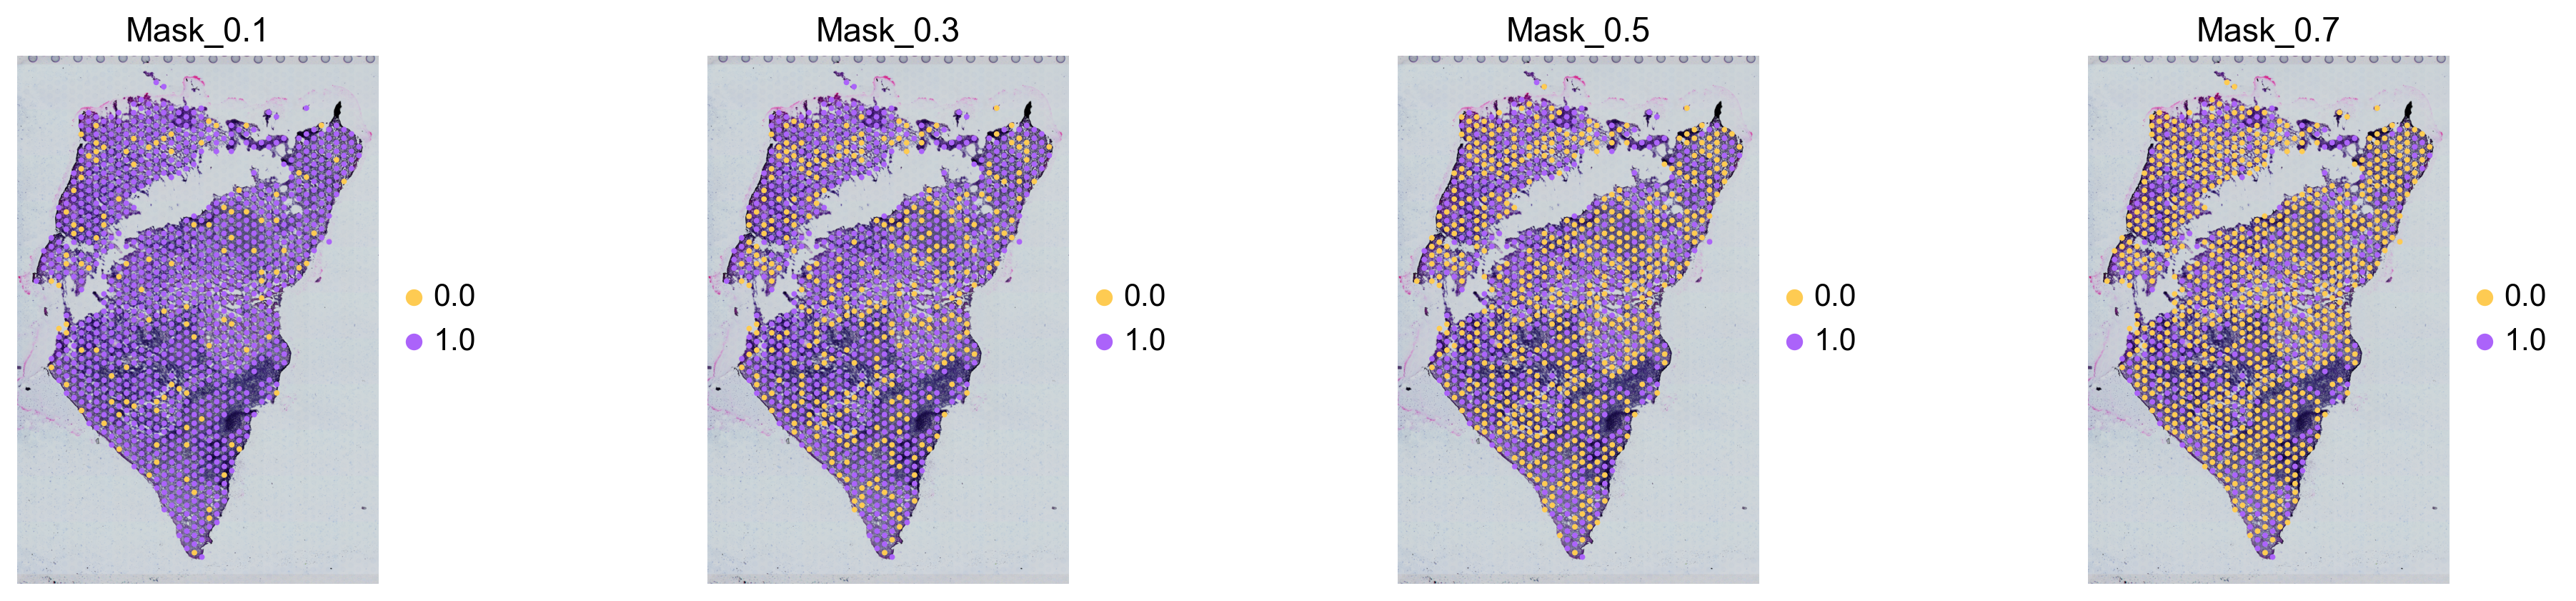

In [15]:
sc.pl.spatial(adata, color=list(masked_stgs.keys()), palette=[palette[-1],palette[-7]], save=f"_mask_test_place.pdf")

### Compare the reconstruction MSE with different methods

In [16]:
mask_rate = [0.1,0.3,0.5,0.7]
adata_truth = sc.read_h5ad(f'data/OSCC/sample_1/sample_1_preprocessed.h5ad')
sc.pp.normalize_total(adata_truth, target_sum=1e4)
sc.pp.log1p(adata_truth)
sc.pp.highly_variable_genes(adata_truth, flavor="seurat_v3", n_top_genes=1000,subset=True)
adata_truth

AnnData object with n_obs × n_vars = 1131 × 1000
    obs: 'pathologist_anno.x', 'sample_id.x', 'cluster_annotations', 'in_tissue', 'row', 'col', 'x', 'y'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'pathologist_anno.x_colors', 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'
    layers: 'processed'

In [17]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc

In [35]:
mse_scores, acc_scores = [], []
for mr in mask_rate:
    print(f"Calculation for rate={mr}...")
    adata_sp = sc.read_loom(f'{trial_name}/outputs/adata_sp_Mask_{mr}_attr.loom')
    mask_id = np.load(f"{trial_name}/outputs/mask_id_{mr}.npy",allow_pickle=True)
    obs_names = adata.obs_names.to_numpy()
    idx = [np.argwhere(obs_names==i).item() for i in mask_id]
    sp_idx = np.array(adata_sp.obs['spot_instance'] == "Inferred")
    gene_names_sp = [f'{name}_with_padding' for name in adata_truth.var_names]
    y = adata_truth.X.A[idx,:].reshape(-1)
    y_hat = adata_sp.obs[gene_names_sp].to_numpy()[sp_idx,:].reshape(-1)
    mse_scores.append(mse(y,y_hat))
    y_label = (y>0)*1
    y_hat_label = (y_hat>1)*1
    acc_scores.append(acc(y_label, y_hat_label))
    print(f"mse: {mse_scores[-1]}; acc: {acc_scores[-1]}")

Calculation for rate=0.1...
mse: 0.227135065507547; acc: 0.9303008849557522
Calculation for rate=0.3...
mse: 0.24409630682018865; acc: 0.9279203539823009
Calculation for rate=0.5...
mse: 0.25364690633294357; acc: 0.9271256637168142
Calculation for rate=0.7...
mse: 0.2713264823113975; acc: 0.9239620733249052


In [36]:
mse_scores, acc_scores 

([0.227135065507547,
  0.24409630682018865,
  0.25364690633294357,
  0.2713264823113975],
 [0.9303008849557522,
  0.9279203539823009,
  0.9271256637168142,
  0.9239620733249052])

In [ ]:
for mr in mask_rate:
    adata_sp = sc.read_loom(f'{trial_name}/outputs/adata_sp_Mask_{mr}.loom')
    idx = np.array(adata_sp.obs['spot_instance'] == "Inferred")
    obs_names = adata_sp.obs['obs_names'].iloc[idx].to_numpy().reshape(-1)
    np.save(f"{trial_name}/outputs/mask_id_{mr}",obs_names)